In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

## Data Description

El dataset fue obtenido del archivo CSV *morosidad_train_test.csv* y se almaceno en la variable *dfmorosidad*, este presenta 14 columnas y 1194 filas (registros). La descripción de las columnas son:

- idPrestamo: Identificador del préstamo 
- Target: Indica si cayó en mora (1) o cumplió con los pagos (0)
- monthy_debt_capacity: Capacidad de endeudamiento mensual
- var_employment_time_in_months: Cuantos meses seguidos lleva trabajando en su trabajo actual
- approved_amount: monto solicitado
- approved_term: cuotas solicitadas
- approved_interest_amount: interés total que pagará
- var_net_income: salario
- person_gender: sexo del solicitante
- credit_history_marital_status: Estado civil
- var_max_sbs_qual_12m: peor estado que haya estado categorizado en la SBS en los últimos 12 meses
- person_degree_type_desc: Nivel de educación
- default_request_term: Escogió el número de cuotas que se le ofreció (1)
- default_request_amount: Escogió el monto de dinero que se le ofreció (1)

En un estado inicial, la variable *var_employment_time_in_months* presenta 139 datos perdidos.

In [2]:
dfmorosidad = pd.DataFrame(pd.read_csv('./morosidad_train_test.csv'))

In [3]:
dfmorosidad.head(2)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375,FEMALE,S,NORMAL,Secundaria,0,0


In [4]:
dfmorosidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   idPrestamo                     1194 non-null   object 
 1   target                         1194 non-null   int64  
 2   monthly_debt_capacity          1194 non-null   object 
 3   var_employment_time_in_months  1055 non-null   float64
 4   approved_amount                1194 non-null   object 
 5   approved_term                  1194 non-null   int64  
 6   approved_interest_amount       1194 non-null   object 
 7   var_net_income                 1194 non-null   float64
 8   person_gender                  1194 non-null   object 
 9   credit_history_marital_status  1194 non-null   object 
 10  var_max_sbs_qual_12m           1194 non-null   object 
 11  person_degree_type_desc        1194 non-null   object 
 12  default_request_term           1194 non-null   i

## Data Exploration

### Integer Variable's type

Los tipos de dato de las variables *monthly_debt_capacity*, *approved_amount*, *approved_interest_amount* estan en formato *object*. Creamos una función que detecta los caracteres en una variable.

In [5]:
def contains_char_comma(df, variables, characters=[',']):
    
    dfchar = pd.DataFrame(columns=characters, index=variables)
    
    for character in characters:
        lst = []
        for variable in variables:
            column =  df[variable].str.contains(character)
            total = column.sum().astype(int)
            lst.append(total)
        
        dfchar[character] = pd.Series(lst).values
        
    return dfchar

In [6]:
variables = ['monthly_debt_capacity', 'approved_amount', 'approved_interest_amount']
contains_char_comma(dfmorosidad, variables)

,","
monthly_debt_capacity,120
approved_amount,1120
approved_interest_amount,136


Luego, buscaremos en qué posición se encuentra el caracter ',' (decimal o unidad de millar).

In [7]:
def contains_coma_sample(df, columns, character=','):
    for column in columns:
        print("-", column, end="\t: ")
        serie = df[column].str.contains(character)
        serie = df[serie][column]
        serie = serie.sample(1)
        print(serie.values)

In [8]:
contains_coma_sample(dfmorosidad, variables)

- monthly_debt_capacity	: ['1,112.49']
- approved_amount	: ['2,200']
- approved_interest_amount	: ['2,131.81']


Podemos notar que en los 3 casos la coma ',' representa la unidad de millar, por ello, lo quitaremos y trasnformaremos a tipo flotante.

In [9]:
def transform_coma(df, columns, character=','):
    for column in columns:
        df[column] = df[column].str.replace(',', '')
        df[column] = df[column].astype(float)
    return df

In [10]:
dfmorosidad = transform_coma(dfmorosidad, variables)

In [11]:
dfmorosidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   idPrestamo                     1194 non-null   object 
 1   target                         1194 non-null   int64  
 2   monthly_debt_capacity          1194 non-null   float64
 3   var_employment_time_in_months  1055 non-null   float64
 4   approved_amount                1194 non-null   float64
 5   approved_term                  1194 non-null   int64  
 6   approved_interest_amount       1194 non-null   float64
 7   var_net_income                 1194 non-null   float64
 8   person_gender                  1194 non-null   object 
 9   credit_history_marital_status  1194 non-null   object 
 10  var_max_sbs_qual_12m           1194 non-null   object 
 11  person_degree_type_desc        1194 non-null   object 
 12  default_request_term           1194 non-null   i

### NaN values

Luego, analizamos los mínimos y máximos de las variables. Podemos observar dos casos que requiere atención:
- La variable *var_employment_time_in_months* posee mìnimo -1, asumimos que significa no existe el dato y lo remplazamos con NaN.
- La variable *var_net_income* posee mínimo 0, asumimos que es un error y lo remplazamos con NaN. 
- La variable *default_request_amount* posee siempre el valor 0, lo quitaremos del análisis pues asumimos que el cliente nunca acepta el monto que se ofrece.

In [12]:
dfmorosidad.describe()

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,default_request_amount
count,1194.000000,1194.000000,1055.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.0
mean,0.294807,596.292119,34.236019,2181.825796,6.481575,415.200854,2726.751860,0.507538,0.0
std,0.456147,476.308950,27.120370,1575.524133,3.020757,418.867230,1869.715874,0.500153,0.0
min,0.000000,110.820000,-1.000000,500.000000,1.000000,22.820000,0.000000,0.000000,0.0
25%,0.000000,362.155000,11.000000,1100.000000,6.000000,152.320000,1780.082500,0.000000,0.0
50%,0.000000,491.585000,25.000000,1500.000000,6.000000,281.390000,2385.176667,1.000000,0.0
75%,1.000000,672.155000,62.000000,2500.000000,6.000000,429.990000,3087.641667,1.000000,0.0
max,1.000000,7243.200000,87.000000,12200.000000,12.000000,2311.120000,28587.000000,1.000000,0.0


In [13]:
dfmorosidad['var_employment_time_in_months'] = np.where(dfmorosidad['var_employment_time_in_months'] == -1,
                                                        np.nan,
                                                        dfmorosidad['var_employment_time_in_months'])

In [14]:
dfmorosidad['var_net_income'] = np.where(dfmorosidad['var_net_income'] == 0,
                                         np.nan,
                                         dfmorosidad['var_net_income'])

In [15]:
del dfmorosidad['default_request_amount']

Analizamos la cantidad de nulos en cada variable y por cada cliente. En las variables tenemos:
- 142 var_employment_time_in_months (11.89%)
- 37 var_net_income (3.09%)

Del total de 1194 clientes:
- 1017 clientes poseen 13 variables completas
- 176 clientes poseen 12 variables completas
- 2 clientes poseen 11 variables completas

In [16]:
#dfmorosidad.isna().sum()
dfmorosidad.isna().mean()

idPrestamo                       0.000000
target                           0.000000
monthly_debt_capacity            0.000000
var_employment_time_in_months    0.118928
approved_amount                  0.000000
approved_term                    0.000000
approved_interest_amount         0.000000
var_net_income                   0.030988
person_gender                    0.000000
credit_history_marital_status    0.000000
var_max_sbs_qual_12m             0.000000
person_degree_type_desc          0.000000
default_request_term             0.000000
dtype: float64

In [17]:
serie1 = dfmorosidad.notna().sum(axis=1)
serie1 = serie1.value_counts()
#serie1 = serie1 / serie1.sum()
#serie1 = serie1*100
serie1

13    1017
12     175
11       2
dtype: int64

Analizamos la correlación de NaNs forma visual, y concluimos que no poseen relación directamente,

<AxesSubplot:>

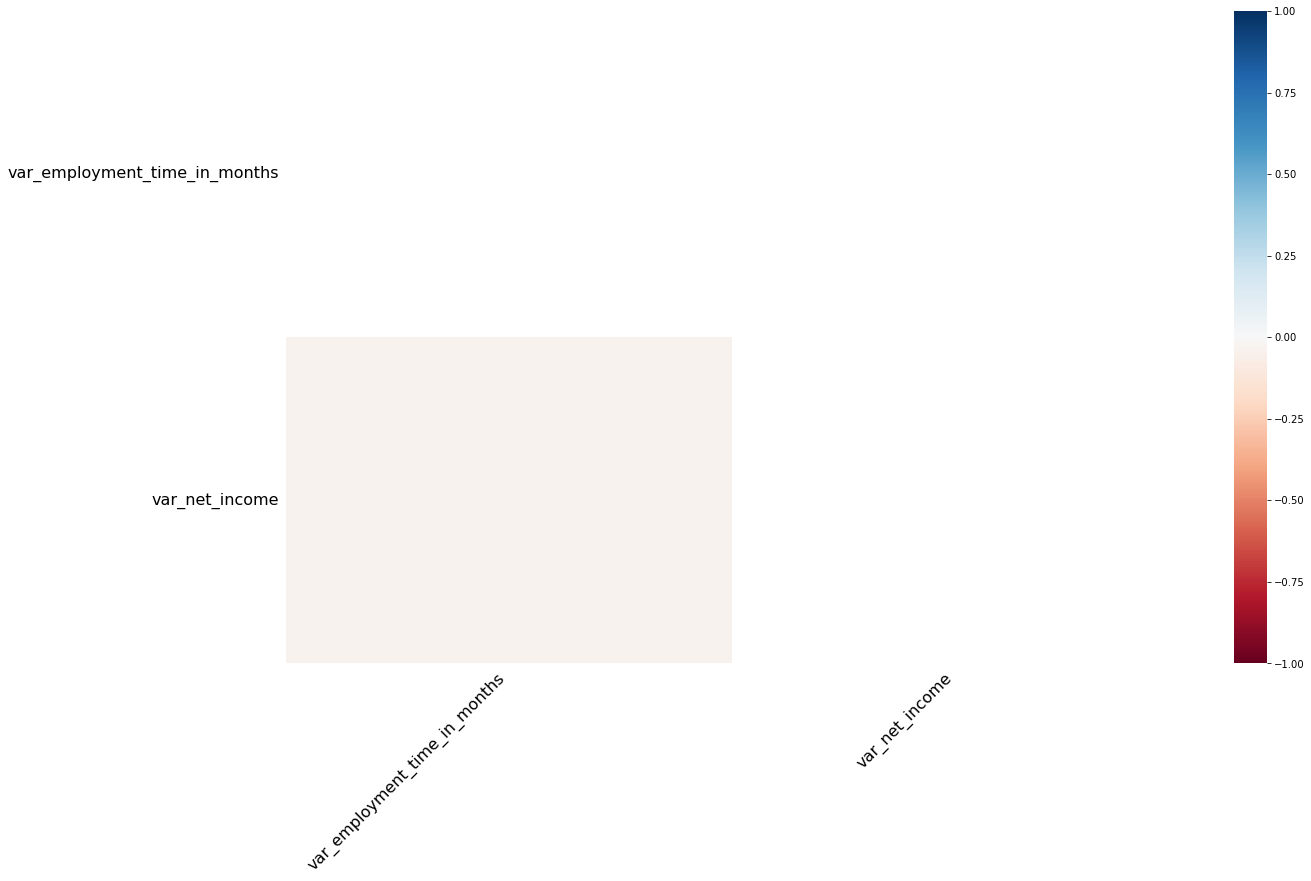

In [18]:
msno.heatmap(dfmorosidad)

Ahora la correlación de las variables, donde concluimos que:
- *var_employment_time_in_months* no posee una alta correlación con las variables restantes
- *var_net_income* posee una alta correlación con *monthly_debt_capacity* 

<AxesSubplot:>

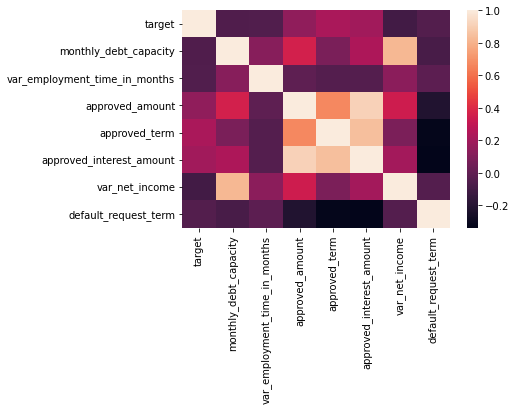

In [19]:
corr = dfmorosidad.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Por ahora borramos todas las variables con NaN de valor.

In [20]:
dfmorosidad.dropna(inplace=True)

In [21]:
dfmorosidad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1193
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   idPrestamo                     1017 non-null   object 
 1   target                         1017 non-null   int64  
 2   monthly_debt_capacity          1017 non-null   float64
 3   var_employment_time_in_months  1017 non-null   float64
 4   approved_amount                1017 non-null   float64
 5   approved_term                  1017 non-null   int64  
 6   approved_interest_amount       1017 non-null   float64
 7   var_net_income                 1017 non-null   float64
 8   person_gender                  1017 non-null   object 
 9   credit_history_marital_status  1017 non-null   object 
 10  var_max_sbs_qual_12m           1017 non-null   object 
 11  person_degree_type_desc        1017 non-null   object 
 12  default_request_term           1017 non-null   i

## Outliers

Buscamos los outliers de cada variable numérica.

<AxesSubplot:>

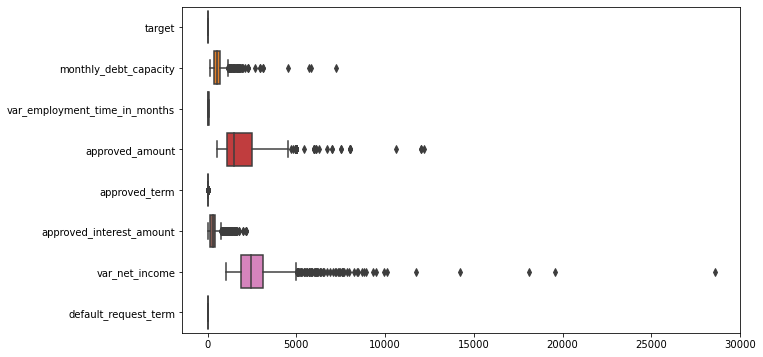

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=dfmorosidad, orient="h")

Aplicamos el *turkey method* para eliminar los outliers de la variable *var_net_income*, *approved_amount*, *monthly_debt_capacity*

In [23]:
def turkey_method(df, variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    
    iqr = q3 -q1
    outerfence = 3*iqr
    
    outerfence_below = q1 - outerfence
    outerfence_above = q3 + outerfence
    outliers_prob = []
    
    for index, x in df[variable].iteritems():
        if x <= outerfence_below or x >= outerfence_above:
            outliers_prob.append(index)
    
    return outliers_prob

In [24]:
outliers_income = turkey_method(dfmorosidad, 'var_net_income')
outliers_income

[120,
 220,
 222,
 241,
 250,
 261,
 274,
 328,
 420,
 422,
 503,
 646,
 666,
 669,
 767,
 784,
 793,
 810,
 836,
 856,
 890,
 916,
 976,
 999,
 1031,
 1053,
 1063,
 1120]

In [25]:
outliers_appamount = turkey_method(dfmorosidad, 'approved_amount')
outliers_appamount

[112, 115, 194, 247, 287, 767, 856, 951, 972, 976, 1031, 1053, 1083, 1169]

In [26]:
outliers_debcapacity = turkey_method(dfmorosidad, 'monthly_debt_capacity')
outliers_debcapacity

[21,
 77,
 112,
 194,
 220,
 222,
 235,
 241,
 247,
 250,
 261,
 274,
 422,
 424,
 535,
 646,
 666,
 767,
 784,
 810,
 856,
 890,
 916,
 954,
 976,
 999,
 1031,
 1037,
 1053,
 1072]

In [27]:
outliers_total = np.unique(outliers_income + outliers_appamount + outliers_debcapacity)
outliers_total

array([  21,   77,  112,  115,  120,  194,  220,  222,  235,  241,  247,
        250,  261,  274,  287,  328,  420,  422,  424,  503,  535,  646,
        666,  669,  767,  784,  793,  810,  836,  856,  890,  916,  951,
        954,  972,  976,  999, 1031, 1037, 1053, 1063, 1072, 1083, 1120,
       1169])

In [28]:
dfmorosidad = dfmorosidad.drop(index=outliers_total)

###  Plots base on categories

Vamos a verificar cuantas personas cayeron en mora.

<AxesSubplot:xlabel='target', ylabel='count'>

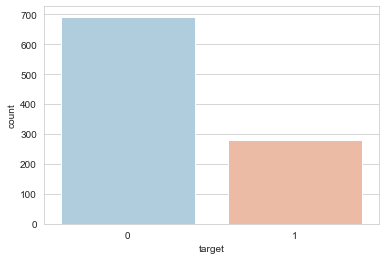

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='target', data=dfmorosidad, palette='RdBu_r')

In [30]:
dfmorosidad.groupby('target').agg({'idPrestamo':'count'})

,idPrestamo
target,
0,692
1,280


Observemos la distribución basado en el género.

<AxesSubplot:xlabel='target', ylabel='count'>

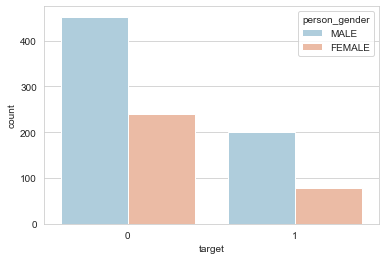

In [31]:
sns.countplot(x='target', hue='person_gender', data=dfmorosidad, palette='RdBu_r')

In [32]:
dfmorosidad.groupby('person_gender').agg({'target':'sum'})

,target
person_gender,
FEMALE,79
MALE,201


Ahora, busquemos la distribución basado el estado civil del cliente.

<AxesSubplot:xlabel='target', ylabel='count'>

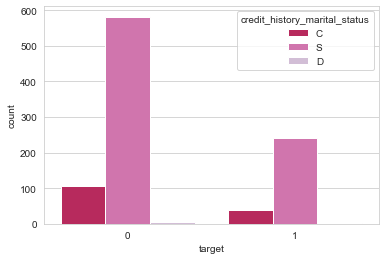

In [33]:
sns.countplot(x='target', hue='credit_history_marital_status', data=dfmorosidad, palette='PuRd_r')

<AxesSubplot:xlabel='target', ylabel='count'>

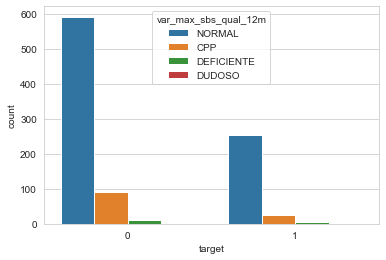

In [34]:
sns.countplot(x='target', hue='var_max_sbs_qual_12m', data=dfmorosidad)

<AxesSubplot:xlabel='target', ylabel='count'>

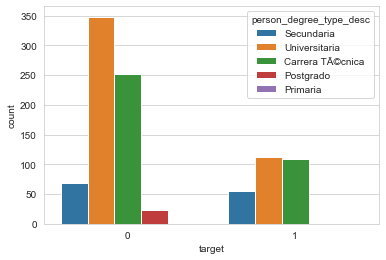

In [35]:
sns.countplot(x='target', hue='person_degree_type_desc', data=dfmorosidad)

## Data Preparation

### Converting Categorical Features

Ahora vamos a convertir los valores objeto a dummies con el one_hot_encoding

In [36]:
dfmorosidad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 1193
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   idPrestamo                     972 non-null    object 
 1   target                         972 non-null    int64  
 2   monthly_debt_capacity          972 non-null    float64
 3   var_employment_time_in_months  972 non-null    float64
 4   approved_amount                972 non-null    float64
 5   approved_term                  972 non-null    int64  
 6   approved_interest_amount       972 non-null    float64
 7   var_net_income                 972 non-null    float64
 8   person_gender                  972 non-null    object 
 9   credit_history_marital_status  972 non-null    object 
 10  var_max_sbs_qual_12m           972 non-null    object 
 11  person_degree_type_desc        972 non-null    object 
 12  default_request_term           972 non-null    in

Iniciaremos con la variable *person_gender*, nos quedaremos con la vaible *MALE*, donde 1 significa es hombre y 0 no lo es, es decir, es mujer.

In [37]:
gender = pd.get_dummies(dfmorosidad['person_gender'], drop_first=True)
gender

,MALE
0,1
1,0
2,0
3,1
4,0
...,...
1189,1
1190,0
1191,1
1192,1


In [38]:
dfmorosidad = pd.concat([dfmorosidad, gender], axis=1)
del dfmorosidad['person_gender']

Luego, la variable *credit_history_marital_status*, vemos su distribución, y realizamos el proceso similar a *person_gender* sin embargo, .no eliminamos ninguna columna

In [39]:
dfmorosidad.groupby('credit_history_marital_status').agg({'idPrestamo': 'count'})

,idPrestamo
credit_history_marital_status,
C,143
D,7
S,822


In [40]:
maritalstatus = pd.get_dummies(dfmorosidad['credit_history_marital_status'], prefix="matitalstatus_")
maritalstatus

,matitalstatus__C,matitalstatus__D,matitalstatus__S
0,1,0,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1189,0,0,1
1190,0,0,1
1191,0,0,1
1192,0,0,1


In [41]:
dfmorosidad = pd.concat([dfmorosidad, maritalstatus], axis=1)
del dfmorosidad['credit_history_marital_status']

También para la variable *var_max_sbs_qual_12m*, vemos su distribución.

In [42]:
dfmorosidad.groupby('var_max_sbs_qual_12m').agg({'idPrestamo': 'count'})

,idPrestamo
var_max_sbs_qual_12m,
CPP,114
DEFICIENTE,14
DUDOSO,1
NORMAL,843


Dado que esta categoría es nominal, remplazaremos los valores según el [brochure de la central de riesgo](https://www.consumidor.gob.pe/documents/127561/1460393/CentralDeRiesgos.pdf/3314584b-9d2b-fb8a-ee77-54cc310518ec#:~:text=Categoria%20Normal%20(%200%20)%20Categoria%20con,la%20clasificaci%C3%B3n%20depender%C3%A1%20de%20la)

In [43]:
def set_sbs(sbs):
    if sbs == "NORMAL":
        return 0
    elif sbs == "CPP":
        return 1
    elif sbs == "DEFICIENTE":
        return 2
    else:
        return 3

In [44]:
dfmorosidad["var_max_sbs_qual_12m"] = dfmorosidad["var_max_sbs_qual_12m"].apply(set_sbs)
dfmorosidad["var_max_sbs_qual_12m"].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
1189    0
1190    0
1191    0
1192    1
1193    0
Name: var_max_sbs_qual_12m, Length: 972, dtype: int32

In [45]:
dfmorosidad.groupby('var_max_sbs_qual_12m').agg({'idPrestamo': 'count'})

,idPrestamo
var_max_sbs_qual_12m,
0,843
1,114
2,14
3,1


Finalmente, para la variable categórica nominal *person_degree_type_desc* lo remplazaremos según el nivel de estudio.

In [46]:
dfmorosidad.groupby('person_degree_type_desc').agg({'idPrestamo': 'count'})

,idPrestamo
person_degree_type_desc,
Carrera TÃ©cnica,361
Postgrado,26
Primaria,1
Secundaria,123
Universitaria,461


In [47]:
def set_estudio(estudio):
    if estudio == "Primaria":
        return 0
    elif estudio == "Secundaria":
        return 1
    elif estudio == "Carrera TÃ©cnica":
        return 2
    elif estudio == "Universitaria":
        return 3
    else:
        return 4

In [48]:
dfmorosidad["person_degree_type_desc"] = dfmorosidad["person_degree_type_desc"].apply(set_estudio)
dfmorosidad["person_degree_type_desc"].astype(int)

0       1
1       1
2       1
3       3
4       3
       ..
1189    2
1190    2
1191    1
1192    2
1193    2
Name: person_degree_type_desc, Length: 972, dtype: int32

In [49]:
dfmorosidad.groupby('person_degree_type_desc').agg({'idPrestamo': 'count'})

,idPrestamo
person_degree_type_desc,
0,1
1,123
2,361
3,461
4,26


Antes de dividir la data, eliminamos la variable *idPrestamo*.

In [50]:
del dfmorosidad['idPrestamo']

### Train Test Split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
predictors = [var for var in dfmorosidad if var != 'target']
predictors

['monthly_debt_capacity',
 'var_employment_time_in_months',
 'approved_amount',
 'approved_term',
 'approved_interest_amount',
 'var_net_income',
 'var_max_sbs_qual_12m',
 'person_degree_type_desc',
 'default_request_term',
 'MALE',
 'matitalstatus__C',
 'matitalstatus__D',
 'matitalstatus__S']

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(dfmorosidad.drop('target', axis=1),
                                                   dfmorosidad['target'], test_size=0.20,
                                                   stratify=dfmorosidad['target'],
                                                   random_state=100)

Comprobamos que la distribución de 0's y 1's en la variable *target* funciona.

In [54]:
Y_train.mean()

0.2882882882882883

In [55]:
Y_test.mean()

0.28717948717948716

## Training and evaluating the ML model

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
logmodel_l1 = LogisticRegression(penalty="l1", solver="liblinear")
logmodel_l1.fit(X_train, Y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [58]:
logmodel_l1.coef_[0]

array([ 4.00909207e-04, -2.95356625e-03,  3.19633823e-04,  3.59741512e-02,
        6.10871083e-04, -5.41655395e-04, -3.19769194e-01, -4.40669040e-01,
        0.00000000e+00,  4.53710478e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

Luego podemos analizar que variables son las más importantes para nuestro modelo

In [59]:
list( zip(predictors, logmodel_l1.coef_[0]))

[('monthly_debt_capacity', 0.0004009092066763792),
 ('var_employment_time_in_months', -0.0029535662474143884),
 ('approved_amount', 0.00031963382282564453),
 ('approved_term', 0.03597415118134083),
 ('approved_interest_amount', 0.0006108710827581416),
 ('var_net_income', -0.0005416553945627243),
 ('var_max_sbs_qual_12m', -0.31976919449388136),
 ('person_degree_type_desc', -0.4406690399985085),
 ('default_request_term', 0.0),
 ('MALE', 0.4537104775185337),
 ('matitalstatus__C', 0.0),
 ('matitalstatus__D', 0.0),
 ('matitalstatus__S', 0.0)]

Esto, lo podemos mostrar de una manera gráfica.

In [60]:
import matplotlib

Text(0.5, 1.0, 'Coefficient Regression')

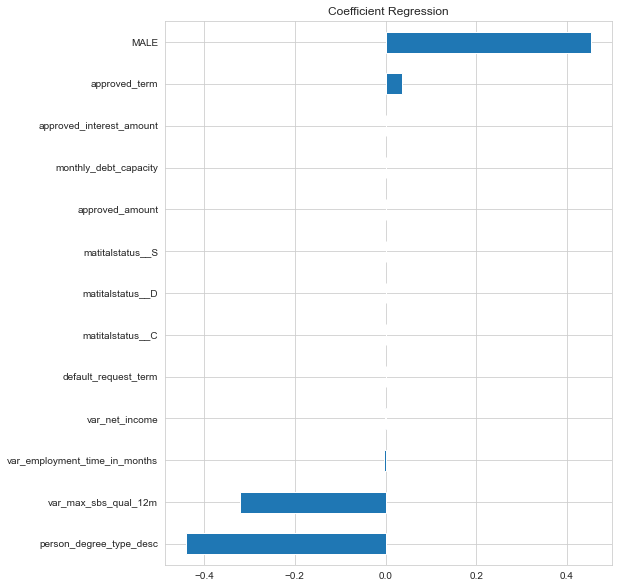

In [61]:
coef = pd.Series(logmodel_l1.coef_[0], index=predictors)

coef_plot = pd.concat([coef.sort_values()])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef_plot.plot(kind="barh")
plt.title("Coefficient Regression")

Podemos observar qué variables tiene mayor relevancia para el modelo, en este caso *MALE*, *approved_term* tienen una relación positiva, esto quiere decir a medida que incrementa dichas variables, también incrementa la posibilidad de que sea moroso. Por otro lado, la relación que muestra *var_max_sbs_qual_12m*, *person_degree_type_desc* es negativa, es decir, a medida que incrementa estas variables, la posibilidad de que la variable 'target' sea 1 es menor.

Ahora predecimos con la data de test y analizamos su score.

In [62]:
predictions = logmodel_l1.predict(X_test[predictors])
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

Además podemos ver la probabilidad de ser 0 o ser 1.

In [63]:
prediction_prob = logmodel_l1.predict_proba(X_test[predictors])
prediction_prob

array([[0.64012579, 0.35987421],
       [0.52914513, 0.47085487],
       [0.6739994 , 0.3260006 ],
       [0.79593856, 0.20406144],
       [0.69296898, 0.30703102],
       [0.85490928, 0.14509072],
       [0.8725223 , 0.1274777 ],
       [0.61553605, 0.38446395],
       [0.73807712, 0.26192288],
       [0.87122281, 0.12877719],
       [0.80786096, 0.19213904],
       [0.650783  , 0.349217  ],
       [0.37872919, 0.62127081],
       [0.64440333, 0.35559667],
       [0.4535203 , 0.5464797 ],
       [0.6935693 , 0.3064307 ],
       [0.74285592, 0.25714408],
       [0.48830487, 0.51169513],
       [0.59671262, 0.40328738],
       [0.65533561, 0.34466439],
       [0.55213778, 0.44786222],
       [0.61478302, 0.38521698],
       [0.92352038, 0.07647962],
       [0.83023682, 0.16976318],
       [0.8134772 , 0.1865228 ],
       [0.73203329, 0.26796671],
       [0.8307075 , 0.1692925 ],
       [0.46411923, 0.53588077],
       [0.92974972, 0.07025028],
       [0.27373593, 0.72626407],
       [0.

Verificamos nuestra precisión usando confusion_matrix y clasification_report

In [64]:
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       139
           1       0.59      0.23      0.33        56

    accuracy                           0.73       195
   macro avg       0.67      0.58      0.58       195
weighted avg       0.71      0.73      0.69       195



## Testeamos con más algoritmos de clasificación

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

In [67]:
mod1_rf = RandomForestClassifier()
mod2_et = ExtraTreesClassifier()
mod3_gc = BaggingClassifier()
mod4_ab = AdaBoostClassifier()
mod5_dt = DecisionTreeClassifier()
mod6_lr = LogisticRegression()
mod7_svm = SVC()
mod8_mnb = MultinomialNB()
mod9_gnb = GaussianNB()

In [68]:
alg = ['RandomForestClassifier', 'ExtraTreesClassifier', 'BaggingClassifier', 
      'AdaBoostClassifier', 'DecisionTreeClassifier', 'LogisticRegression',
      'SVC', 'MultinomialNB', 'GaussianNB']
scores_mean = []
scores_std = []
models = [mod1_rf, mod2_et, mod3_gc, mod4_ab, mod5_dt, mod6_lr, mod7_svm, mod8_mnb, mod9_gnb]

for model in models:
    scores = cross_val_score(model, X_train, Y_train, scoring="accuracy", cv=10, n_jobs=-1)
    mean_scores = scores.mean()
    std_scores = scores.std()
    scores_mean.append(mean_scores)
    scores_std.append(std_scores)

Lo convertimos a un dataframe para apreciar los resultados finales

In [69]:
resultados = pd.DataFrame(scores_mean, index=alg, columns=['score']).sort_values(by='score', ascending=False)
resultados['std'] = scores_std
resultados

,score,std
AdaBoostClassifier,0.740060,0.040202
LogisticRegression,0.733616,0.040040
RandomForestClassifier,0.732351,0.036493
SVC,0.720729,0.029477
GaussianNB,0.702697,0.049181
BaggingClassifier,0.701465,0.042038
ExtraTreesClassifier,0.698768,0.026203
MultinomialNB,0.669331,0.034660
DecisionTreeClassifier,0.628155,0.039507
